In [1]:
import os
os.chdir('..')

In [2]:
from src.experiment import CLIPGraphRun
from src.models.explainer import CLIPGraphExplainer, ArtGraphCaptumExplainer, GraphIntegratedGradients
from src.data import DataDict
from src.utils import load_ruamel
from src.visualization.clip_vis import get_img_path, get_style_by_case_id
from src.visualization.utils import SessionStateKey
from torch_geometric.explain import ThresholdConfig
import torch
import pandas as pd
import json
from neo4j import GraphDatabase
from torch_geometric import seed_everything
seed_everything(42)

In [3]:
def get_prediction(run: CLIPGraphRun, case_id: int) -> torch.Tensor:
    class_feats = run.model.encode_graph(
        run.graph.x_dict, run.graph.edge_index_dict, normalize=True
    )
    img_tensor = (
        run.test_loader.dataset[case_id].get(DataDict.IMAGE).unsqueeze(0).to(run.device)
    )
    img_feats = run.model.encode_image(img_tensor, normalize=True)
    prediction = img_feats @ class_feats.T
    return  {
        SessionStateKey.LOGITS: prediction,
        SessionStateKey.IMG_FEATS: img_feats,
        SessionStateKey.GRAPH_FEATS: class_feats,
    }

In [4]:
def get_mappings(root: str, mapping_file: str) -> dict[dict[int, str]]:
    files = {k.split('_')[0]: pd.read_csv(f"{root}/{k}", names=["idx", "name"]).to_dict()["name"] for k in os.listdir(root)}
    with open(mapping_file) as f:
        artwork_mapping = json.load(f)
    artwork_mapping = {int(k): v for k, v in artwork_mapping.items()}
    files["artwork"] = {artwork_mapping[k]: v for k, v in files["artwork"].items() if k in artwork_mapping.keys()}
    return files

In [6]:
parameters = load_ruamel('./configs_cineca/proposed_model/style/normal_clip_graph_sage3.yaml')
parameters["clean_out_dir"] = False
parameters["model"]["gnn"]["params"]["dropout"] = 0.0
run = CLIPGraphRun(parameters=parameters)

Loading general parameters...
Done!
Loading dataloaders...
Done!
Loading model...
Done!
Loading metrics...
Done!
Loading tokenizer...
Done!
Loading criterion...
Done!
Loading optimizer...
Done!
Loading scheduler...
Done!
Loading early stop callback...
Done!


In [7]:
run.load_state_dict()

loading state dict


In [8]:
class2idx, idx2class = run.get_class_maps()

In [9]:
explainer = CLIPGraphExplainer(
    device=run.device,
    image_preprocess="clip",
    mappings=get_mappings(
        root="./data/external/artgraph2bestemotions/mapping/",
        mapping_file="./data/processed/graph/0_5/artwork_mapping.json",
    ),
    neo4j_driver=GraphDatabase.driver(uri='bolt://localhost:7688', auth=("neo4j", "neo4j")),
    neo4j_db="neo4j"
)

## CHOOSE THE TEST INSTANCE

In [10]:
from ipywidgets import IntSlider

test_instance = IntSlider(
    value=0,
    min=0,
    max=len(run.test_loader.dataset)-1,
    step=1,
    description="Choose the test instance",
    orientation="horizontal",
)
display(test_instance)

IntSlider(value=0, description='Choose the test instance', max=11646)

In [33]:
image_style = get_style_by_case_id(run=run, case_id=test_instance.value)
image_style

'baroque'

In [34]:
img_pth = get_img_path(run=run, case_id=test_instance.value)
img_pth

'data/raw/images-resized/pietro-da-cortona_piet-1625.jpg'

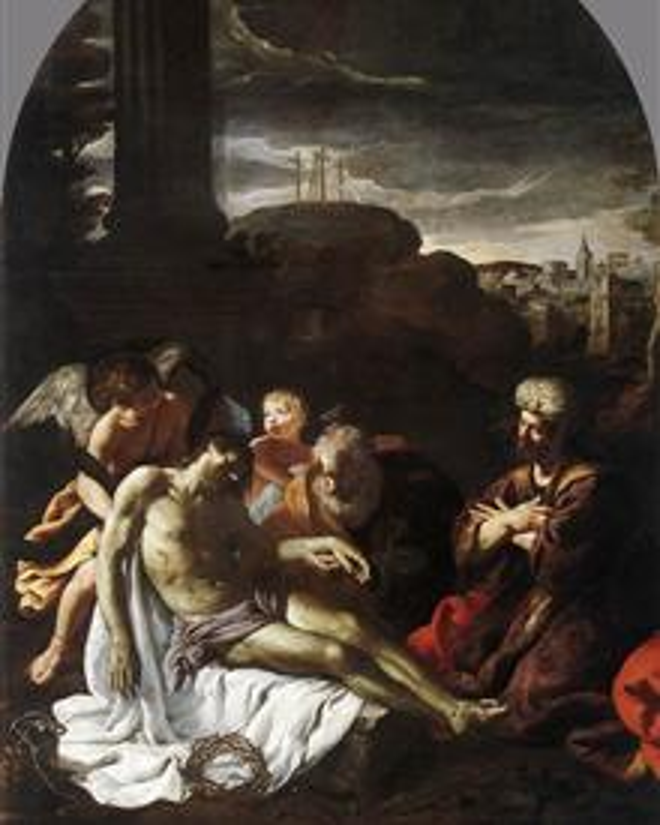

In [35]:
from PIL import Image
img = Image.open(img_pth).convert("RGB")
img.resize((img.width*3, img.height*3))

### EXPLAIN THE IMAGE

In [36]:
out = get_prediction(run=run, case_id=test_instance.value)
pred_idx = out[SessionStateKey.LOGITS].argmax().cpu().item()
pred_class = idx2class[pred_idx]
overlayed_image = explainer.explain_image(
            img_path=img_pth,
            model=run.model,
            reference_feats=out[SessionStateKey.GRAPH_FEATS],
            target=pred_idx,
            overlayed=True,
        )

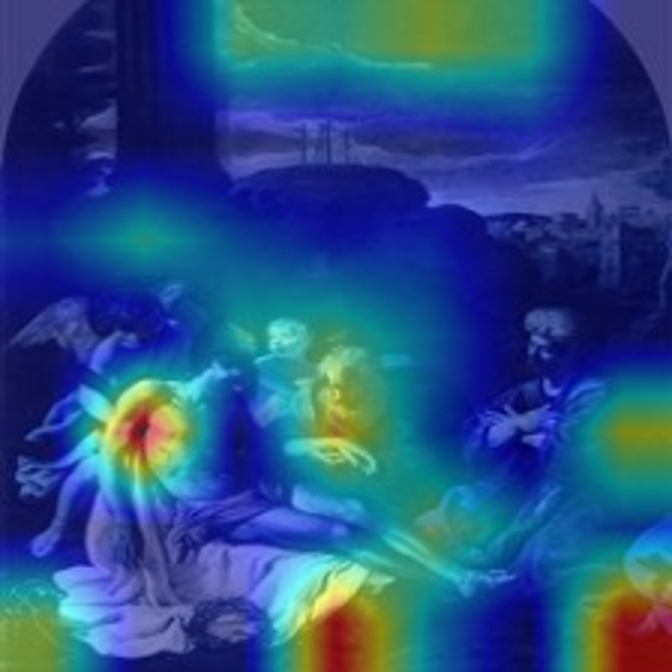

In [37]:
ov = Image.fromarray(overlayed_image, "RGB")
ov.resize((ov.width*3, ov.height*3))

In [38]:
f"Explaination of the image for class {pred_class}"

'Explaination of the image for class baroque'

### EXPLAIN THE GRAPH

In [39]:
explanation = explainer.explain_graph(
    model=run.model,
    graph=run.graph,
    reference_feats=out[SessionStateKey.IMG_FEATS].detach(),
    target_node=class2idx[pred_class],
    algo=ArtGraphCaptumExplainer(GraphIntegratedGradients, graph=run.graph),
    algo_kwargs=dict(
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type="object",
        model_config=dict(
            mode="multiclass_classification",
            task_level="node",
            return_type="raw",
        ),
        threshold_config=ThresholdConfig(threshold_type="topk", value=200),
    ),
)
explainer.plot_explanation(explanation, run.graph.metadata(), run.graph)


GraphWidget(layout=Layout(height='800px', width='100%'))

In [ ]:
from tqdm import tqdm
correct_case_ids = set()
for case_id in tqdm(range(len(run.test_loader.dataset))):
    image_style = get_style_by_case_id(run=run, case_id=case_id)
    out = get_prediction(run=run, case_id=case_id)
    pred_idx = out[SessionStateKey.LOGITS].argmax().cpu().item()
    pred_class = idx2class[pred_idx]
    if image_style == pred_class:
        #print(f"{image_style} è uguale a {pred_class} per l'immagine {case_id}")
        correct_case_ids.add(case_id)

    

 61%|██████    | 7069/11647 [10:53<07:03, 10.81it/s]


KeyboardInterrupt: 

In [ ]:
correct_case_ids

{0,
 1,
 2,
 3,
 4,
 6,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 22,
 25,
 26,
 27,
 28,
 30,
 31,
 33,
 36,
 38,
 42,
 44,
 45,
 47,
 48,
 49,
 53,
 54,
 56,
 59,
 60,
 61,
 64,
 65,
 68,
 69,
 70,
 71,
 74,
 75,
 77,
 80,
 82,
 84,
 85,
 87,
 90,
 91,
 93,
 95,
 96,
 98,
 100,
 101,
 102,
 105,
 106,
 107,
 108,
 111,
 112,
 113,
 115,
 116,
 118,
 119,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 129,
 132,
 136,
 138,
 139,
 141,
 143,
 146,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 168,
 169,
 170,
 171,
 174,
 175,
 176,
 178,
 180,
 181,
 182,
 183,
 184,
 185,
 188,
 189,
 192,
 193,
 194,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 207,
 208,
 209,
 210,
 211,
 213,
 214,
 215,
 217,
 224,
 225,
 227,
 229,
 230,
 231,
 232,
 234,
 235,
 236,
 238,
 240,
 241,
 242,
 243,
 245,
 249,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 261,
 264,
 269,
 270,
 274,
 278,
 280,
 284,
 285,
 286,
 289,
 290,
 291,
 

In [ ]:
import random
random.choice(list(correct_case_ids))

In [ ]:
len(correct_case_ids)